#### **Classification using Neural Networks (Keras)**
- Dataset: Pima Indian Dataset [link](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
- Library: Keras, Tensorflow

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.models import load_model

# when you save your data in your gdrive
# from google.colab import drive
# drive.mount('/content/drive/')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# load the dataset
df = pd.read_csv('sample_data/diabetes.csv')

# print the columns name
print(df.columns)
print()

# rename the column DiabetesPedigreeFunction with DPF
df = df.rename({'DiabetesPedigreeFunction':'DMF'}, axis=1)
display(df.head())

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DMF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [0]:
# determine which columns are identified, only attributes 
zero_fields = df.columns[0:-3].tolist()

# list number of 0-entries in each of the given columns
def check_zero_entries(data, column):
  print('Zero entries in each columns')
  for col in column:
    print('{:15}: {}' .format(col, len(data.loc[ data[col] == 0, col ])))

# check for each columns
check_zero_entries(df, zero_fields)

Zero entries in each columns
Pregnancies    : 111
Glucose        : 5
BloodPressure  : 35
SkinThickness  : 227
Insulin        : 374
BMI            : 11


In [0]:
# create a copy data
df_full = df.copy()

# data imputation for zero value
def impute_zero_field(data, column):
    # get non zero values each column
    nonzero_vals = data.loc[data[column] != 0, column]
    
    # calculate the average
    avg = (np.sum(nonzero_vals) / len(nonzero_vals)).round(2)
    
    # total number of 0-entries
    k = len(data.loc[ data[column] == 0, column])   
    
    # replace 0 with the average
    data.loc[ data[column] == 0, column ] = avg

    print('{:15} ; fixed {:4} entries with {}'.format(column, k, avg))

# perform data imputation on attributes
for col in zero_fields:
    impute_zero_field(df_full, col)

# display the result
display(df_full.head())

Pregnancies     ; fixed  111 entries with 4.49
Glucose         ; fixed    5 entries with 121.69
BloodPressure   ; fixed   35 entries with 72.41
SkinThickness   ; fixed  227 entries with 29.15
Insulin         ; fixed  374 entries with 155.55
BMI             ; fixed   11 entries with 32.46


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DMF,Age,Outcome
0,6.00,148.0,72.0,35.00,155.55,33.6,0.627,50,1
1,1.00,85.0,66.0,29.00,155.55,26.6,0.351,31,0
2,8.00,183.0,64.0,29.15,155.55,23.3,0.672,32,1
3,1.00,89.0,66.0,23.00,94.00,28.1,0.167,21,0
4,4.49,137.0,40.0,35.00,168.00,43.1,2.288,33,1


#### Simple Data Exploration

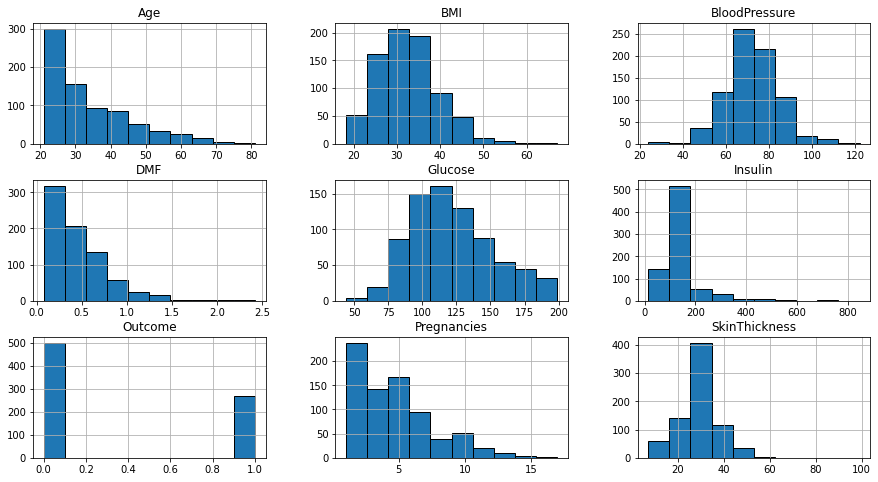

In [0]:
# plot the imputed data
df_full.hist(figsize=(15,8), edgecolor='black')
plt.show()

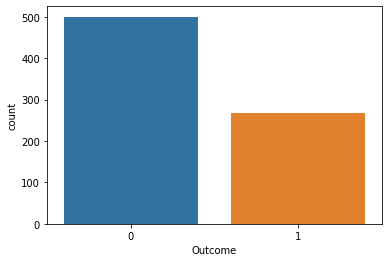

In [0]:
# distribution of outcome (label)
sns.countplot(x=df_full['Outcome'])

In [0]:
# data description
df_full.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DMF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.493997,121.686784,72.405404,29.152409,155.549089,32.457500,0.471876,33.240885,0.348958
std,2.975395,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,4.490000,117.000000,72.205000,29.150000,155.550000,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.550000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Training and Testing Split

In [0]:
# Split into features and labes from imputed data
X = df_full.iloc[:,:-1].values
y = df_full.iloc[:,-1].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

# print the train and test set
print('Train Size {}'.format(X_train.shape))
print('Test Size {}'.format(X_test.shape))

Train Size (537, 8)
Test Size (231, 8)


#### Neural Networks

In [0]:
# fix random seed for reproducibility
np.random.seed(10)

# Build the Networks with 3 hidden layers
def neural_network(n_inputs=8):
    model = Sequential()
    
    # input layer = 8 nodes, hidden Layer = 16 nodes
    model.add(Dense(16, input_dim=n_inputs, activation='relu'))
    
    # hidden layer = 8 nodes
    model.add(Dense(8, activation='relu'))

    # hidden layer = 8 nodes
    model.add(Dense(8, activation='relu'))
    
    # output layer = 1 node --> binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model, you can use other loss function/optimizer
    model.compile(loss='binary_crossentropy', 
                  optimizer='sgd', 
                  metrics=['accuracy'])
    return model

# generate the model
nn_model = neural_network()

# summarized the mode
nn_model.summary()

# init the parameters
n_epochs = 200
n_batch_size = 16
val_split = 0.2

# option 1: train the network and validate with 0.1 of training data
# history = nn_model.fit(X_train, y_train, validation_split=val_split, epochs=100, batch_size=10, verbose=False)

# option 2: train the network and validate with test data
print('\nstart training ....')
history = nn_model.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=n_epochs, 
                       batch_size=n_batch_size, 
                       verbose=False)

print('finish .....')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________

start training ....
finish .....


#### Model Evaluation

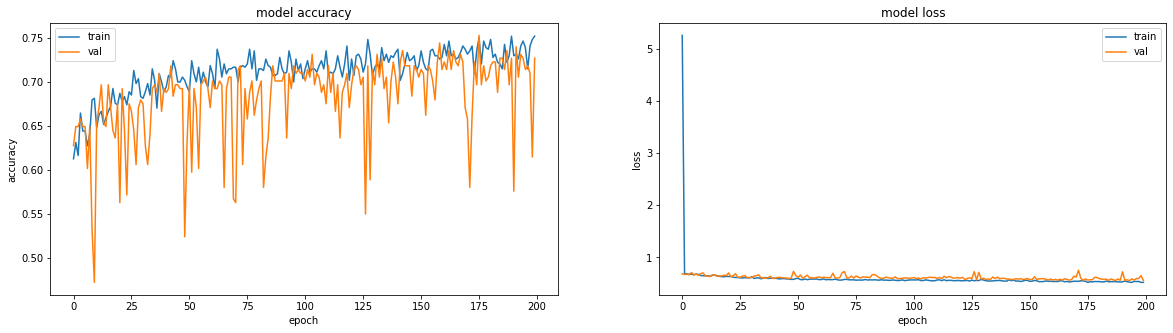

In [0]:
# summarize for accuracy score
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

# summarize for loss score
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [0]:
# Evaluate the model (training accuracy)
train_scores = nn_model.evaluate(X_train, y_train, verbose=False)
print('(Training) %s: %.2f%%' % (nn_model.metrics_names[1], train_scores[1]*100))

# Evaluate the model (testing accuracy)
test_scores = nn_model.evaluate(X_test, y_test, verbose=False)
print('(Testing) %s: %.2f%%' % (nn_model.metrics_names[1], test_scores[1]*100))

(Training) accuracy: 75.05%
(Testing) accuracy: 72.73%


In [0]:
# make probability prediction with the model
prediction = nn_model.predict(X_test)

# round prediction
rounded = [round(x[0]) for x in prediction]

# make class predictions with the model
cls_prediction = nn_model.predict_classes(X_test)

Confusion Matrix


,Predicted No,Predicted Yes
Actual No,138,12
Actual Yes,51,30


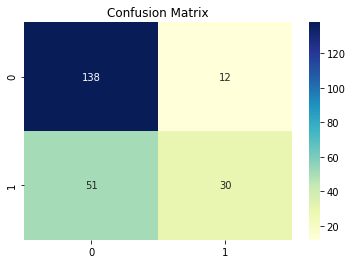


Classification Report
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       150
           1       0.71      0.37      0.49        81

    accuracy                           0.73       231
   macro avg       0.72      0.65      0.65       231
weighted avg       0.72      0.73      0.70       231



In [0]:
# evaluate the performance
print('Confusion Matrix')
display(pd.DataFrame(confusion_matrix(y_test, cls_prediction),
             columns=['Predicted No', 'Predicted Yes'],
             index=['Actual No', 'Actual Yes']
             ))

# plot the confusion matrix
print()
sns.heatmap(confusion_matrix(y_test, cls_prediction), annot=True, fmt='.3g', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.show()

# classification report
print('\nClassification Report')
print(classification_report(y_test, cls_prediction))

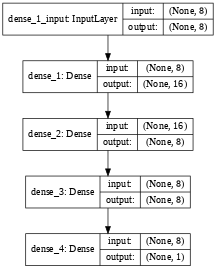

In [16]:
# visualize the architecture
plot_model(nn_model, show_shapes=True, show_layer_names=True, dpi=50)

In [0]:
# # creates a HDF5 file 'my_model.h5'
# nn_model.save('my_model.h5')

# # load the model and use it
# model = load_model('my_model.h5')
# model.summary()